<div align="center" style="border: 3px solid #4CAF50; padding: 20px; border-radius: 15px; background: linear-gradient(135deg, #FFDEE9, #B5FFFC); width: 80%; margin: auto;">
  <h1 style="color: #FF5733; font-family: 'Arial Black', Gadget, sans-serif;">🎬 Dr. Labib</h1>
  <p style="color: #1A1AFA; font-size: 18px; font-style: italic;">Turning Signs into Words – Your Deaf Video Translator</p>
  <p style="color: #000000; font-weight: bold;">📹 Translate. Understand. Connect.</p>
</div>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
responsibleailab_signtalk_ghana_path = kagglehub.dataset_download('responsibleailab/signtalk-ghana')

print('Data source import complete.')

100%|██████████| 21.5G/21.5G [03:58<00:00, 96.7MB/s]

Extracting files...


Data source import complete.


In [11]:
import pandas as pd
import os

DATASET_PATH = '/root/.cache/kagglehub/datasets/responsibleailab/signtalk-ghana/versions/2/SignTalk-GH'

df = os.path.join(DATASET_PATH, 'Metadata.xlsx')
VIDEO_DIR = os.path.join(DATASET_PATH, 'Videos')
# df.head(5)

In [ ]:
# !pip uninstall mediapipe -y
# !pip install mediapipe==0.10.13
# !pip install opencv-python tqdm



import mediapipe as mp

print("Version:", mp.__version__)
print("Has solutions:", hasattr(mp, 'solutions'))

Version: 0.10.13
Has solutions: True


In [ ]:
import pandas as pd
import os
from glob import glob
import mediapipe as mp
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
df = pd.read_excel(df)

# Rename columns
df.columns = ['Sentence ID', 'Sentence Text', 'Category']

# Ensure Sentence ID is string
df['Sentence ID'] = df['Sentence ID'].astype(str)

# Drop rows with missing sentence text
df = df.dropna(subset=['Sentence Text'])

TARGET_CATEGORY = 'Questions from patients'

df = df[df['Category'] == TARGET_CATEGORY].reset_index(drop=True)

print("Remaining category:", TARGET_CATEGORY)
print("Total sentences:", len(df))

Original unique sentences: 4031
Remaining category: Questions from patients
Total sentences: 200


In [13]:
# Map videos to Sentence IDs
video_files = glob(os.path.join(VIDEO_DIR, '*.mp4'))
video_to_id = {}

for v in video_files:
    base = os.path.basename(v).replace('.mp4', '')
    id_str = ''.join([c for c in base if c.isdigit()])
    if id_str and id_str in df['Sentence ID'].values:
        video_to_id.setdefault(id_str, []).append(v)

df['Video Paths'] = df['Sentence ID'].map(video_to_id)
df = df.dropna(subset=['Video Paths']).reset_index(drop=True)

print("Final unique sentences:", len(df))
print("Final total videos to process:", sum(len(paths) for paths in df['Video Paths']))

Final unique sentences: 200
Final total videos to process: 400


# <center>Frame/Landmarks Extraction<center>

In [ ]:
# Setting Up Media Pipe for Extracting Frames

# Fast MediaPipe (complexity=0, face parts disabled)
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=0,
    enable_segmentation=False,
    refine_face_landmarks=False
)

In [ ]:
def extract_fast_keypoints(video_path, max_frames=80):
    cap = cv2.VideoCapture(video_path)
    frames_kp = []
    frame_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        kp = np.zeros(258)
        idx = 0

        # Pose
        if results.pose_landmarks:
            for lm in results.pose_landmarks.landmark:
                kp[idx:idx+3] = [lm.x, lm.y, lm.z]
                idx += 3

        # Hands
        for hand_lm in [results.left_hand_landmarks, results.right_hand_landmarks]:
            if hand_lm:
                for lm in hand_lm.landmark:
                    kp[idx:idx+3] = [lm.x, lm.y, lm.z]
                    idx += 3

        frames_kp.append(kp)
        frame_count += 1

    cap.release()

    frames_kp = np.array(frames_kp)
    if len(frames_kp) < max_frames:
        frames_kp = np.pad(frames_kp, ((0, max_frames - len(frames_kp)), (0, 0)), mode='constant')

    # Normalize
    frames_kp = (frames_kp - frames_kp.mean(axis=0)) / (frames_kp.std(axis=0) + 1e-6)

    return frames_kp.astype(np.float32)

In [ ]:
# Extract keypoints (ab kam videos, jaldi complete hoga)
for _, row in tqdm(df.iterrows(), total=len(df)):
    for v_path in row['Video Paths']:
        kp_filename = os.path.basename(v_path).replace('.mp4', '.npy')
        kp_path = os.path.join(OUTPUT_DIR, kp_filename)

        if not os.path.exists(kp_path):
            kp = extract_fast_keypoints(v_path)
            np.save(kp_path, kp)

print("Keypoint extraction completed for reduced dataset!")

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 200/200 [56:17<00:00, 16.89s/it]

Keypoint extraction completed for reduced dataset!


### Landmarks extracted successfully.

In [17]:

sample_file = os.path.join('/content/keypoints_output',
                           os.listdir('/content/keypoints_output')[0])

kp = np.load(sample_file)

print("Shape:", kp.shape)
print("Mean:", kp.mean())
print("Std:", kp.std())
print("Min:", kp.min())
print("Max:", kp.max())

# Non-zero frames check
non_zero_frames = np.sum(np.any(kp != 0, axis=1))
print("Non-zero frames:", non_zero_frames, "/ 80")

Shape: (80, 258)
Mean: 5.9142593e-09
Std: 0.9296762
Min: -4.4940333
Max: 3.9388535
Non-zero frames: 80 / 80


(80, 258)


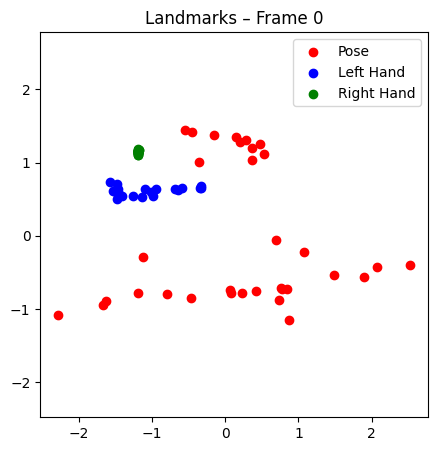

In [18]:
import matplotlib.pyplot as plt

# kisi aik file ka path
npy_path = '/content/keypoints_output/2701B.npy'
kp = np.load(npy_path)

print(kp.shape)  # (80, 258)

frame_id = 0
frame = kp[frame_id]


# Pose (first 99 values)
pose = frame[:99].reshape(-1, 3)

# Left hand (next 63)
left_hand = frame[99:162].reshape(-1, 3)

# Right hand (last 63)
right_hand = frame[162:225].reshape(-1, 3)


plt.figure(figsize=(5, 5))

# Pose
plt.scatter(pose[:, 0], -pose[:, 1], c='red', label='Pose')

# Left hand
plt.scatter(left_hand[:, 0], -left_hand[:, 1], c='blue', label='Left Hand')

# Right hand
plt.scatter(right_hand[:, 0], -right_hand[:, 1], c='green', label='Right Hand')

plt.legend()
plt.title(f'Landmarks – Frame {frame_id}')
plt.axis('equal')
plt.show()

In [19]:
from sklearn.preprocessing import LabelEncoder

# Sentence IDs ko encode karo
le = LabelEncoder()
df['label'] = le.fit_transform(df['Sentence ID'])

print(df[['Sentence ID', 'label']].head())
print("Total classes (sentences):", df['label'].nunique())

  Sentence ID  label
0        2701      0
1        2702      1
2        2703      2
3        2704      3
4        2705      4
Total classes (sentences): 200


In [20]:
# Linking the .npy frames with the labels.

X = []
y = []

for _, row in df.iterrows():
    label = row['label']
    for v_path in row['Video Paths']:
        npy_name = os.path.basename(v_path).replace('.mp4', '.npy')
        npy_path = os.path.join('/content/keypoints_output', npy_name)

        if os.path.exists(npy_path):
            kp = np.load(npy_path)
            X.append(kp)
            y.append(label)

X = np.array(X)   # (num_videos, 80, 258)
y = np.array(y)   # (num_videos,)

In [21]:
print(X.shape, y.shape)

(400, 80, 258) (400,)


In [22]:
from sklearn.model_selection import train_test_split

unique_sentences = df['Sentence ID'].unique()

train_sent, val_sent = train_test_split(
    unique_sentences,
    test_size=0.2,
    random_state=42
)

In [23]:
train_idx = []
val_idx = []

idx = 0
for _, row in df.iterrows():
    for _ in row['Video Paths']:
        if row['Sentence ID'] in train_sent:
            train_idx.append(idx)
        else:
            val_idx.append(idx)
        idx += 1

In [24]:
X_train = X[train_idx]
y_train = y[train_idx]

X_val = X[val_idx]
y_val = y[val_idx]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (320, 80, 258) (320,)
Val: (80, 80, 258) (80,)


In [25]:
# Check no sentence leakage
train_labels = set(y_train)
val_labels = set(y_val)

print("Overlap:", train_labels.intersection(val_labels))

Overlap: set()


In [ ]:
# Normalization

def z_score_normalize(sequence, eps=1e-6):
    """
    sequence: (T, D) -> e.g. (80, 258)
    """
    mean = sequence.mean(axis=0)
    std = sequence.std(axis=0)
    normalized = (sequence - mean) / (std + eps)
    return normalized.astype(np.float32)

In [27]:
kp = np.load("keypoints_output/2701B.npy")      # (80, 258)
kp_norm = z_score_normalize(kp)


# <center>Data Augmentation<center>

In [28]:
def add_gaussian_noise(sequence, sigma=0.02):
    noise = np.random.normal(0, sigma, sequence.shape)
    return (sequence + noise).astype(np.float32)

In [29]:
def temporal_jitter(sequence, drop_prob=0.1):
    T, D = sequence.shape
    new_seq = []

    for t in range(T):
        if np.random.rand() > drop_prob:
            new_seq.append(sequence[t])

    # agar frames kam ho gaye to last frame repeat
    while len(new_seq) < T:
        new_seq.append(new_seq[-1])

    return np.array(new_seq[:T]).astype(np.float32)

In [30]:
def spatial_shift(sequence, shift_std=0.01):
    seq = sequence.copy()

    # x,y,z order assumed
    for i in range(0, seq.shape[1], 3):
        seq[:, i]   += np.random.normal(0, shift_std)  # x
        seq[:, i+1] += np.random.normal(0, shift_std)  # y
        # z unchanged

    return seq.astype(np.float32)

In [31]:
def augment_sequence(sequence):
    seq = sequence.copy()

    if np.random.rand() < 0.7:
        seq = add_gaussian_noise(seq)

    if np.random.rand() < 0.5:
        seq = temporal_jitter(seq)

    if np.random.rand() < 0.5:
        seq = spatial_shift(seq)

    return seq

In [32]:

# --- Paths ---
INPUT_DIR = '/content/keypoints_output'  # existing .npy files
AUG_DIR = '/content/keypoints_output_augmented'
os.makedirs(AUG_DIR, exist_ok=True)

# Augmentation functions
def flip_left_right(kp):
    """Flip horizontally (mirror) for X-axis"""
    kp_flipped = kp.copy()
    # Pose X coordinates (first 12 dims)
    kp_flipped[:, 0::3] = 1 - kp_flipped[:, 0::3]  # assuming normalized 0-1 space
    return kp_flipped

def scale_keypoints(kp, scale=1.1):
    """Scale landmarks around center"""
    kp_scaled = kp.copy()
    mean = kp_scaled.mean(axis=0)
    kp_scaled = (kp_scaled - mean) * scale + mean
    return kp_scaled

def add_noise(kp, noise_level=0.02):
    """Add small random noise"""
    kp_noisy = kp.copy()
    kp_noisy += np.random.normal(0, noise_level, kp_noisy.shape)
    return kp_noisy

# --- Process each file ---
npy_files = glob(os.path.join(INPUT_DIR, '*.npy'))
for file_path in npy_files:
    kp = np.load(file_path)

    # Original save
    base_name = os.path.basename(file_path).replace('.npy', '')
    np.save(os.path.join(AUG_DIR, f'{base_name}_orig.npy'), kp)

    # Augmentations
    kp_flip = flip_left_right(kp)
    np.save(os.path.join(AUG_DIR, f'{base_name}_flip.npy'), kp_flip)

    kp_scale = scale_keypoints(kp, scale=1.1)
    np.save(os.path.join(AUG_DIR, f'{base_name}_scale.npy'), kp_scale)

    kp_noise = add_noise(kp, noise_level=0.02)
    np.save(os.path.join(AUG_DIR, f'{base_name}_noise.npy'), kp_noise)

print(f"Augmentation complete! Augmented files saved to {AUG_DIR}")


Augmentation complete! Augmented files saved to /content/keypoints_output_augmented


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [34]:
import glob

# Path to .npy files
FEATURE_DIR = '/content/keypoints_output'
files = sorted(glob.glob(os.path.join(FEATURE_DIR, '*.npy')))

# Load features
X = np.array([np.load(f) for f in files])

# Load labels from dataframe
y_labels = []
for f in files:
    basename = os.path.basename(f).replace('.npy','')
    sentence_id = ''.join([c for c in basename if c.isdigit()])
    label = df[df['Sentence ID'] == sentence_id]['Sentence Text'].values[0]
    y_labels.append(label)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_labels)  # integer labels
y = tf.keras.utils.to_categorical(y)  # one-hot

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (320, 80, 258) (320, 197)
Test shape: (80, 80, 258) (80, 197)


# <center> LSTM/GRU <center>

In [36]:
def build_lstm_gru(input_shape, num_classes, rnn_type='LSTM'):
    model = Sequential()
    if rnn_type=='LSTM':
        model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
    else:
        model.add(GRU(256, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128) if rnn_type=='LSTM' else GRU(128))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train.shape[1:]  # (80, 258)
num_classes = y_train.shape[1]

lstm_model = build_lstm_gru(input_shape, num_classes, rnn_type='LSTM')
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80, 256)        │       527,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 197)            │        25,413 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 749,893 (2.86 MB)

 Trainable params: 749,893 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('lstm_model_best.h5', monitor='val_accuracy', save_best_only=True)
]

history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)

print("Moodel Training and Saving Completed")

Moodel Training and Saving Completed


In [38]:
import pickle

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("label_encoder.pkl saved successfully")

label_encoder.pkl saved successfully


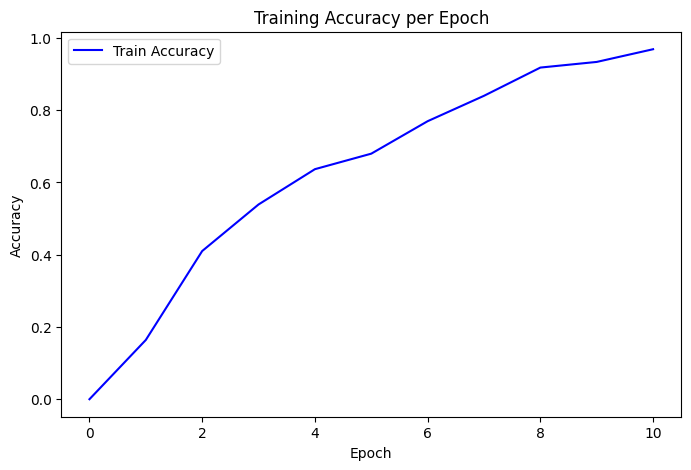

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div align="center" style="border: 3px solid #50b4a5ff; padding: 20px; border-radius: 15px; background: linear-gradient(135deg, #FFDEE9, #B5FFFC); width: 80%; margin: auto;">
  <h1 style="color: #FF5733; font-family: 'Arial Black', Gadget, sans-serif;">🎐Dr. Labib</h1>
  <p style="color: #1A1AFA; font-size: 18px; font-style: italic;">Turning Signs into Words – Your Deaf Video Translator</p>
  <p style="color: #000000; font-weight: bold;">📹 Translate. Understand. Connect.</p>
  
  <!-- Inspiring message -->
  <p style="font-size: 17px; font-weight: bold; color: #FF8C00; margin-top: 20px;">
    🌟 “Breaking barriers, one sign at a time – Empowering every voice!” 🌈
  </p>
</div>